In [1]:
# sys, file and nav packages:
import datetime as dt
import json

# math packages:
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.distributions.empirical_distribution import ECDF

# charting:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import ticker
from matplotlib import colors
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.gridspec import GridSpec
import seaborn as sns

import base64, io, IPython
from PIL import Image as PILImage
from IPython.display import Markdown as md
from IPython.display import display, Math, Latex

# set some parameters:
today = dt.datetime.now().date().strftime("%Y-%m-%d")
start_date = '2020-03-01'
end_date ='2021-05-31'

a_fail_rate = 100

unit_label = 'p/100m'
reporting_unit = 100

# name of the output folder:
name_of_project = 'dist_map'

# get your data:
df= pd.read_csv('checked_sdata_eos_2020_21.csv')

with open("river_basins.json", "r") as infile:
    river_bassins = json.load(infile)

dfBeaches = pd.read_csv("beaches_with_land_use_rates.csv")
dfCodes = pd.read_csv("codes_with_group_names_2015.csv")
dfDims = pd.read_csv("corrected_dims.csv")

# set the index of the beach data to location slug
dfBeaches.set_index('slug', inplace=True)
        
dfCodes.set_index("code", inplace=True)

In [2]:
# this is the aggregated survey data that is being used
fd = df.copy()
fd['loc_dates'] = list(zip(fd.location.values, fd.date.values))
fd['date'] = pd.to_datetime(fd.date)

# the location data for the surveys
dfb = dfBeaches.loc[fd.location.unique()].copy()

In [3]:
# the landuse descriptors are integers, key them to a readable descriptor
# no27 is the results of intersecting buffer to Land use
label_keys = {
    1:"industrial",
    2:"residential",
    3:"government",
    4:"agg_buildings",
    5:"unk_building",
    6:"roads",
    7:"railways",
    8:"airports",
    9:"special",
    10:"recreational",
    11:"orchards",
    12:"vineyards",
    13:"horticulture",
    14:"arable",
    15:"meadows",
    16:"farmpastures",
    17:"alpinemeadows",
    18:"aplinepasteurs",
    19:"closed_forest",
    20:"open_forest",
    21:"brush_forest",
    22:"woods",
    23:"lakes",
    24:"rivers",
    25:"unproductive",
    26:"bareland",
    27:"glaciers"
}

# group the land use into functional groups
group_parts = {'buildings':[2,3,4,5,9],
               'ind':[1],              
               'trans':[6,7,8],
               'recreation':[10],
               'agg':[11, 12, 13, 14, 15, 16, 18],
               'woods':[17,19,20,21,22],
               'water':[23,24],
               'unproductive':[25,26,27]
              }

# make column names based on the key values:
as_1827_part ={k:F"part_{v}" for k,v in label_keys.items()}

# map survey results to these aggregated luse features
som_cols = ['% to buildings',
            '% to ind',
            '% to trans',
            '% to recreation',
            '% to agg',
            '% to woods',
            '% to water',
            '% to unproductive',
                
]

# define functions to map luse data to survey locations
def aggregate_buffer_data(data, cols, bufferdata, label_keys, **kwargs):
    
    # make empty columns for the measured land use features
    for acol in cols:
        data[acol]= 0

    # assign values to each column
    for beach in data.index:
        for label in list(label_keys.values()):        
            try:
                new_data = bufferdata[(bufferdata.slug == beach)&(bufferdata.label == label)].AS18_27.values[0]
            except:
                new_data = 0
            data.loc[beach, label] = new_data
    return data

# account for the area attributed to water by removing the
# the value of water features from land use total
def adjusted_land_use(data, col_keys):
    # total land use
    data['luse_total'] = data.loc[:,list(col_keys.values())].sum(axis=1)

    # amount attributed to water
    data['water_value'] = data.loc[:, ['lakes','rivers']].sum(axis=1)

    # the adjsuted land use
    # remove the water value from land use stats
    data['adjusted_land_use'] = data.luse_total - data.water_value
    
    return data

# determine the ration of each landuse feature to the adjusted total for each buffer
def account_for_adj_luse(data, col_keys):
    for label in list(col_keys.values()):
        a_label = F"part_{label}"
        data[a_label] = data[label]/data['adjusted_land_use']
    return data

# aggregate the groups
def aggregate_the_luse_groups(data, groups, group_parts, as_1827_part):
    for a_group in group_parts.keys():
        part_groups = [as_1827_part[x] for x in group_parts[a_group]]
        new_group = F"% to {a_group}"
        data[new_group] = data.loc[:,part_groups].sum(axis=1)
    
    return data

# merge survey results to land use stats
def assign_luse_stat_to_survey_results(sdata, luse_data, som_cols):
    for a_beach in sdata.location.unique():
        for element in som_cols:
            sdata.loc[sdata.location == a_beach, element] = luse_data.loc[a_beach, element]
    return sdata

# apply method and check results
def check_hypothesis(this_data, some_codes, variables, method):
    myresults = {}
    for i,code in enumerate(some_codes):
        data = this_data[this_data.code == code]
        code_results ={code:{}}
        for j, n in enumerate(variables):
            corr, a_p = method(data[n], data[unit_label])
            if a_p <= 0.05:
                code_results[code].update({n:corr})
        myresults.update(code_results)
    
    return myresults

### 2000 meters codes with an association to a landuse feature

Where p <= 0.05 for Spearmans test for association.

In [4]:
# the buffer results from qgis
lu_2000 = pd.read_csv('luse_2000.csv')
lu_2000.rename(columns={'location':'slug'}, inplace=True)

# make a df with location slug, landuse label and land use value:
for a_num in lu_2000.AS18_27.unique():
    lu_2000.loc[lu_2000.AS18_27==a_num, "label"]=label_keys[a_num]

# the locations that need land use data
data = pd.DataFrame(index = fd.location.unique())

# records with a quantity greater than 30
abundant_codes = fd[fd.quantity > 20].code.unique()

# getting a list of the current landuse categories
add_these_cols = lu_2000.label.unique()

# counting the number of points inside the buffer for each category and location
bufferdata = lu_2000.groupby(['slug','label'], as_index=False).AS18_27.count()

these_groups = list(group_parts.keys())

some_data = aggregate_buffer_data(data, add_these_cols, bufferdata, label_keys)

sd_0 = adjusted_land_use(some_data, label_keys)

sd_1 = account_for_adj_luse(data, label_keys)

sd_2000 = aggregate_the_luse_groups(data, add_these_cols, group_parts, as_1827_part)
sd_2000['dist'] = 2000


fd_luse = assign_luse_stat_to_survey_results(fd, sd_2000,som_cols)    

this_data = fd_luse[[unit_label,*som_cols, 'code']]

myresults = check_hypothesis(this_data, abundant_codes, som_cols, stats.spearmanr)

srho_results_2000 = pd.DataFrame.from_dict(myresults, orient='index')
srho_results_2000.fillna("X", inplace=True)
srho_results_2000['dist'] = 2000

# the survey data with land use attached


In [5]:
srho_results_2000

,% to buildings,% to ind,% to trans,% to recreation,% to agg,% to woods,% to water,% to unproductive,dist
G27,0.320302,0.142424,0.359557,0.302469,-0.284461,-0.164146,0.123172,-0.298779,2000
G200,0.21279,X,X,0.11617,-0.21987,X,0.241411,X,2000
G921,0.120313,X,X,X,X,X,0.169742,-0.172626,2000
G95,0.115165,0.124138,0.187697,0.195286,-0.151915,X,0.124518,-0.169153,2000
G30,0.239966,0.151797,0.277116,0.275198,-0.202422,-0.133838,X,X,2000
G67,-0.150838,X,X,X,X,X,X,X,2000
G178,0.369938,X,0.35621,0.257235,-0.310423,-0.126493,X,-0.326207,2000
G177,0.254905,0.135003,0.318904,0.314786,-0.272465,-0.104776,X,-0.161699,2000
G24,0.106221,X,0.141976,0.107349,-0.118351,-0.128087,X,-0.205846,2000
G25,0.1193,X,0.110049,0.134953,-0.10919,X,0.130293,X,2000


In [6]:
len(srho_results_2000)

33

In [7]:
fd[fd.code.isin(srho_results_2000.index)].quantity.sum()/(fd.quantity.sum())

0.8296251644015783

In [8]:
fd[fd.code.isin(srho_results_2000.index)].groupby('code', as_index=False).quantity.sum()

,code,quantity
0,G10,448
1,G106,592
2,G112,1968
3,G117,1209
4,G149,121
5,G177,521
6,G178,700
7,G200,2136
8,G204,125
9,G208,145


### 2500 meters codes with an association to a landuse feature

Where p <= 0.05 for Spearmans test for association.

In [9]:
# the buffer results from qgis
new_buffer = pd.read_csv('luse_2500.csv')
new_buffer.rename(columns={'location':'slug'}, inplace=True)

# make a df with location slug, landuse label and land use value:
for a_num in new_buffer.AS18_27.unique():
    new_buffer.loc[new_buffer.AS18_27==a_num, "label"]=label_keys[a_num]

# the locations that need land use data
data = pd.DataFrame(index = fd.location.unique())

# records with a quantity greater than 30
abundant_codes = fd[fd.quantity > 30].code.unique()

# getting a list of the current landuse categories
add_these_cols = lu_2000.label.unique()

# counting the number of points inside the buffer for each category and location
bufferdata = new_buffer.groupby(['slug','label'], as_index=False).AS18_27.count()

some_data = aggregate_buffer_data(data, add_these_cols, bufferdata, label_keys)

sd_0 = adjusted_land_use(some_data, label_keys)

sd_1 = account_for_adj_luse(data, label_keys)

sd_2500 = aggregate_the_luse_groups(data, add_these_cols, group_parts, as_1827_part)
sd_2500['dist'] = 2500


fd_luse = assign_luse_stat_to_survey_results(fd, sd_2500,som_cols)    

this_data = fd_luse[[unit_label,*som_cols, 'code']]

myresults = check_hypothesis(this_data, abundant_codes, som_cols, stats.spearmanr)
    

srho_results_2500 = pd.DataFrame.from_dict(myresults, orient='index')
srho_results_2500.fillna("X", inplace=True)
srho_results_2500['dist'] = 2500

# the survey data with land use attached
srho_results_2500

,% to buildings,% to trans,% to recreation,% to agg,% to woods,% to unproductive,% to water,% to ind,dist
G27,0.343982,0.353151,0.289665,-0.300856,-0.160632,-0.331526,X,X,2500
G95,0.149447,0.191291,0.169331,-0.138672,X,-0.20954,0.152909,X,2500
G30,0.255517,0.273768,0.263673,-0.17438,-0.114198,-0.130139,0.102261,X,2500
G67,-0.132362,X,X,X,0.104952,X,X,X,2500
G112,0.110122,X,0.153405,X,-0.111106,X,X,0.123746,2500
G200,0.170412,0.111638,0.118095,-0.235673,X,X,0.221714,X,2500
G178,0.371628,0.344676,0.260189,-0.307018,-0.132225,-0.320133,X,X,2500
G25,0.1285,0.116756,0.12492,X,X,X,0.116392,X,2500
G73,0.13475,0.122102,X,X,X,-0.109623,X,X,2500
G923,0.108511,X,0.105077,-0.118244,X,X,X,X,2500


### 3000 meters codes with an association to a landuse feature

Where p <= 0.05 for Spearmans test for association.

In [10]:
# the buffer results from qgis
new_buffer = pd.read_csv('luse_3000.csv')
new_buffer.rename(columns={'location':'slug'}, inplace=True)

# make a df with location slug, landuse label and land use value:
for a_num in new_buffer.AS18_27.unique():
    new_buffer.loc[new_buffer.AS18_27==a_num, "label"]=label_keys[a_num]

# the locations that need land use data
data = pd.DataFrame(index = fd.location.unique())

# records with a quantity greater than 30
abundant_codes = fd[fd.quantity > 30].code.unique()

# getting a list of the current landuse categories
add_these_cols = new_buffer.label.unique()

# counting the number of points inside the buffer for each category and location
bufferdata = new_buffer.groupby(['slug','label'], as_index=False).AS18_27.count()

some_data = aggregate_buffer_data(data, add_these_cols, bufferdata, label_keys)

sd_0 = adjusted_land_use(some_data, label_keys)

sd_1 = account_for_adj_luse(data, label_keys)

sd_3000 = aggregate_the_luse_groups(data, add_these_cols, group_parts, as_1827_part)
sd_3000['dist'] = 3000
fd_luse = assign_luse_stat_to_survey_results(fd, sd_3000,som_cols)    

this_data = fd_luse[[unit_label,*som_cols, 'code']]

myresults = check_hypothesis(this_data, abundant_codes, som_cols, stats.spearmanr)
    

srho_results_3000 = pd.DataFrame.from_dict(myresults, orient='index')
srho_results_3000.fillna("X", inplace=True)
srho_results_3000['dist'] = 3000

# the survey data with land use attached
srho_results_3000

,% to buildings,% to trans,% to recreation,% to agg,% to woods,% to unproductive,% to water,% to ind,dist
G27,0.344328,0.333869,0.29211,-0.296465,-0.141479,-0.346102,X,X,3000
G95,0.142412,0.182817,0.142483,-0.134517,-0.105196,-0.208186,0.185796,X,3000
G30,0.252695,0.257579,0.227051,-0.163206,X,-0.117843,0.115464,0.100232,3000
G67,-0.133905,-0.119565,-0.110205,X,0.132734,X,X,X,3000
G112,0.101279,X,0.164909,X,-0.136529,X,X,0.143621,3000
G200,0.162835,0.106292,0.14675,-0.226291,X,X,0.221486,X,3000
G178,0.366647,0.337676,0.265285,-0.303623,-0.119136,-0.300133,X,X,3000
G25,0.131776,0.110955,0.108004,X,X,X,0.1178,X,3000
G98,0.10259,0.174254,0.205052,-0.181237,X,-0.169399,X,0.176025,3000
G73,0.133866,0.109784,X,X,X,X,X,X,3000


### 3500 meters codes with an association to a landuse feature

Where p <= 0.05 for Spearmans test for association.

In [11]:
# the buffer results from qgis
new_buffer = pd.read_csv('luse_3500.csv')
new_buffer.rename(columns={'location':'slug'}, inplace=True)

# make a df with location slug, landuse label and land use value:
for a_num in new_buffer.AS18_27.unique():
    new_buffer.loc[new_buffer.AS18_27==a_num, "label"]=label_keys[a_num]

# the locations that need land use data
data = pd.DataFrame(index = fd.location.unique())

# records with a quantity greater than 30
abundant_codes = fd[fd.quantity > 30].code.unique()

# getting a list of the current landuse categories
add_these_cols = lu_2000.label.unique()

# counting the number of points inside the buffer for each category and location
bufferdata = new_buffer.groupby(['slug','label'], as_index=False).AS18_27.count()

some_data = aggregate_buffer_data(data, add_these_cols, bufferdata, label_keys)

sd_0 = adjusted_land_use(some_data, label_keys)

sd_1 = account_for_adj_luse(data, label_keys)

sd_3500 = aggregate_the_luse_groups(data, add_these_cols, group_parts, as_1827_part)
sd_3500['dist'] = 3500
fd_luse = assign_luse_stat_to_survey_results(fd, sd_3500,som_cols)    

this_data = fd_luse[[unit_label,*som_cols, 'code']]

myresults = check_hypothesis(this_data, abundant_codes, som_cols, stats.spearmanr)
    

srho_results_3500 = pd.DataFrame.from_dict(myresults, orient='index')
srho_results_3500.fillna("X", inplace=True)
srho_results_3500['dist'] = 3500

# the survey data with land use attached
srho_results_3500

,% to buildings,% to ind,% to trans,% to recreation,% to agg,% to woods,% to water,% to unproductive,dist
G27,0.325539,0.121071,0.321827,0.314722,-0.274426,-0.115917,0.134844,-0.343779,3500
G95,0.107855,0.106025,0.150334,0.147845,-0.118258,X,0.267814,-0.207847,3500
G30,0.230523,0.15436,0.235979,0.213567,-0.158862,X,0.167705,-0.119043,3500
G67,-0.155885,X,-0.139943,-0.149744,X,0.139882,X,X,3500
G112,0.100953,0.199543,X,0.171943,X,-0.163423,X,X,3500
G117,-0.100426,X,X,X,X,X,X,X,3500
G200,0.163382,X,0.105245,0.158073,-0.210373,X,0.198275,X,3500
G178,0.351266,X,0.325801,0.307952,-0.289836,-0.104573,0.108156,-0.305017,3500
G25,0.122345,X,0.10496,X,X,X,0.137605,X,3500
G73,0.122127,0.118911,0.104433,X,X,X,0.128211,X,3500


### 4000 meters codes with an association to a landuse feature

Where p <= 0.05 for Spearmans test for association.

In [12]:
# the buffer results from qgis
new_buffer = pd.read_csv('luse_4000.csv')
new_buffer.rename(columns={'location':'slug'}, inplace=True)

# make a df with location slug, landuse label and land use value:
for a_num in new_buffer.AS18_27.unique():
    new_buffer.loc[new_buffer.AS18_27==a_num, "label"]=label_keys[a_num]

# the locations that need land use data
data = pd.DataFrame(index = fd.location.unique())

# records with a quantity greater than 30
abundant_codes = fd[fd.quantity > 30].code.unique()

# getting a list of the current landuse categories
add_these_cols = lu_2000.label.unique()

# counting the number of points inside the buffer for each category and location
bufferdata = new_buffer.groupby(['slug','label'], as_index=False).AS18_27.count()

some_data = aggregate_buffer_data(data, add_these_cols, bufferdata, label_keys)

sd_0 = adjusted_land_use(some_data, label_keys)

sd_1 = account_for_adj_luse(data, label_keys)

sd_4000 = aggregate_the_luse_groups(data, add_these_cols, group_parts, as_1827_part)
sd_4000['dist'] = 4000
fd_luse = assign_luse_stat_to_survey_results(fd, sd_4000,som_cols)    

this_data = fd_luse[[unit_label,*som_cols, 'code']]

myresults = check_hypothesis(this_data, abundant_codes, som_cols, stats.spearmanr)
    

srho_results_4000 = pd.DataFrame.from_dict(myresults, orient='index')
srho_results_4000.fillna("X", inplace=True)
srho_results_4000['dist'] = 4000

# the survey data with land use attached
srho_results_4000

,% to buildings,% to ind,% to trans,% to recreation,% to agg,% to woods,% to water,% to unproductive,dist
G27,0.322579,0.10842,0.342943,0.320969,-0.266421,-0.110468,0.160244,-0.326662,4000
G30,0.215224,0.104485,0.220976,0.200386,-0.143312,X,0.196519,-0.104202,4000
G67,-0.180616,X,-0.173851,-0.158195,X,0.150351,X,X,4000
G117,-0.111945,X,X,X,-0.10463,X,X,X,4000
G200,0.16715,X,0.123776,0.144117,-0.186387,X,0.191202,X,4000
G178,0.355846,X,0.359117,0.314306,-0.282009,-0.103969,0.114054,-0.297625,4000
G25,0.117457,X,X,X,X,X,0.140726,X,4000
G73,0.111041,X,X,X,X,X,0.140231,X,4000
G112,X,0.216098,X,0.15515,X,-0.170322,X,X,4000
G89,X,-0.112108,X,X,-0.148128,X,0.174754,X,4000


### 4500 meters codes with an association to a landuse feature

Where p <= 0.05 for Spearmans test for association.

In [13]:
# the buffer results from qgis
new_buffer = pd.read_csv('luse_4500.csv')
new_buffer.rename(columns={'location':'slug'}, inplace=True)

# make a df with location slug, landuse label and land use value:
for a_num in new_buffer.AS18_27.unique():
    new_buffer.loc[new_buffer.AS18_27==a_num, "label"]=label_keys[a_num]

# the locations that need land use data
data = pd.DataFrame(index = fd.location.unique())

# records with a quantity greater than 30
abundant_codes = fd[fd.quantity > 30].code.unique()

# getting a list of the current landuse categories
add_these_cols = lu_2000.label.unique()

# counting the number of points inside the buffer for each category and location
bufferdata = new_buffer.groupby(['slug','label'], as_index=False).AS18_27.count()

some_data = aggregate_buffer_data(data, add_these_cols, bufferdata, label_keys)

sd_0 = adjusted_land_use(some_data, label_keys)

sd_1 = account_for_adj_luse(data, label_keys)

sd_4500 = aggregate_the_luse_groups(data, add_these_cols, group_parts, as_1827_part)
sd_4500['dist'] = 4500

fd_luse = assign_luse_stat_to_survey_results(fd, sd_4500,som_cols)    

this_data = fd_luse[[unit_label,*som_cols, 'code']]

myresults = check_hypothesis(this_data, abundant_codes, som_cols, stats.spearmanr)
    

srho_results_4500 = pd.DataFrame.from_dict(myresults, orient='index')
srho_results_4500.fillna("X", inplace=True)
srho_results_4500['dist'] = 4500

# the survey data with land use attached
srho_results_4500

,% to buildings,% to ind,% to trans,% to recreation,% to agg,% to water,% to unproductive,% to woods,dist
G27,0.326005,0.113605,0.319308,0.331542,-0.259325,0.167055,-0.326169,X,4500
G30,0.199409,X,0.207177,0.196102,-0.119199,0.213029,-0.121245,X,4500
G67,-0.194227,X,-0.193314,-0.16251,X,0.115901,X,0.153371,4500
G117,-0.11054,X,X,X,-0.111516,X,X,X,4500
G200,0.161557,X,0.11148,0.149755,-0.158931,0.184992,X,X,4500
G178,0.366309,X,0.35536,0.324017,-0.273269,0.115037,-0.283913,X,4500
G208,0.101861,X,0.100173,X,-0.123572,X,-0.11176,-0.103935,4500
G73,0.102761,X,X,X,X,0.153014,X,X,4500
Gfoam,-0.106272,-0.107725,X,X,X,0.231096,X,X,4500
G112,X,0.196727,X,0.132183,X,X,X,-0.181029,4500


### 5000 meters codes with an association to a landuse feature

Where p <= 0.05 for Spearmans test for association.

In [14]:
# the buffer results from qgis
lu_2000 = pd.read_csv('luse_5k.csv')
lu_2000.rename(columns={'location':'slug'}, inplace=True)

# make a df with location slug, landuse label and land use value:
for a_num in lu_2000.AS18_27.unique():
    lu_2000.loc[lu_2000.AS18_27==a_num, "label"]=label_keys[a_num]

# the locations that need land use data
data = pd.DataFrame(index = fd.location.unique())

# records with a quantity greater than 30
abundant_codes = fd[fd.quantity > 30].code.unique()

# getting a list of the current landuse categories
add_these_cols = lu_2000.label.unique()

# counting the number of points inside the buffer for each category and location
bufferdata = lu_2000.groupby(['slug','label'], as_index=False).AS18_27.count()

these_groups = list(group_parts.keys())

some_data = aggregate_buffer_data(data, add_these_cols, bufferdata, label_keys)

sd_0 = adjusted_land_use(some_data, label_keys)

sd_1 = account_for_adj_luse(data, label_keys)

sd_5000 = aggregate_the_luse_groups(data, add_these_cols, group_parts, as_1827_part)
sd_5000['dist'] = 5000
fd_luse = assign_luse_stat_to_survey_results(fd, sd_5000,som_cols)    

this_data = fd_luse[[unit_label,*som_cols, 'code']]

myresults = check_hypothesis(this_data, abundant_codes, som_cols, stats.spearmanr)

srho_results_5000 = pd.DataFrame.from_dict(myresults, orient='index')
srho_results_5000.fillna("X", inplace=True)
srho_results_5000['dist'] = 5000

# the survey data with land use attached
srho_results_5000 

,% to buildings,% to ind,% to trans,% to recreation,% to agg,% to water,% to unproductive,% to woods,dist
G27,0.319715,0.130453,0.29783,0.316179,-0.24356,0.168906,-0.313578,X,5000
G30,0.186981,X,0.192731,0.190884,-0.104999,0.215457,-0.129771,X,5000
G67,-0.216371,-0.131283,-0.206335,-0.166623,X,0.116064,X,0.147267,5000
G117,-0.111523,X,-0.112471,X,-0.124841,X,X,X,5000
G200,0.151326,X,0.116147,0.158323,-0.128495,0.187634,X,X,5000
G178,0.369699,0.11334,0.346853,0.320172,-0.261401,0.118711,-0.277548,X,5000
G208,0.114448,X,0.102087,X,-0.124664,X,-0.12602,X,5000
G941,-0.107452,X,-0.133638,X,X,X,0.112302,0.173375,5000
G944,-0.111164,-0.100864,-0.113282,X,X,X,0.107774,0.125616,5000
G923,0.101546,X,X,0.106981,X,X,X,X,5000


### 10000 meters codes with an association to a landuse feature

Where p <= 0.05 for Spearmans test for association.

In [15]:
# the buffer results from qgis
lu_2000 = pd.read_csv('luse_10k.csv')
lu_2000.rename(columns={'location':'slug'}, inplace=True)

# make a df with location slug, landuse label and land use value:
for a_num in lu_2000.AS18_27.unique():
    lu_2000.loc[lu_2000.AS18_27==a_num, "label"]=label_keys[a_num]

# the locations that need land use data
data = pd.DataFrame(index = fd.location.unique())

# records with a quantity greater than 30
abundant_codes = fd[fd.quantity > 30].code.unique()

# getting a list of the current landuse categories
add_these_cols = lu_2000.label.unique()

# counting the number of points inside the buffer for each category and location
bufferdata = lu_2000.groupby(['slug','label'], as_index=False).AS18_27.count()

these_groups = list(group_parts.keys())

some_data = aggregate_buffer_data(data, add_these_cols, bufferdata, label_keys)

sd_0 = adjusted_land_use(some_data, label_keys)

sd_1 = account_for_adj_luse(data, label_keys)

sd_10000 = aggregate_the_luse_groups(data, add_these_cols, group_parts, as_1827_part)
sd_10000['dist'] = 10000
fd_luse = assign_luse_stat_to_survey_results(fd, sd_10000,som_cols)    

this_data = fd_luse[[unit_label,*som_cols, 'code']]

myresults = check_hypothesis(this_data, abundant_codes, som_cols, stats.spearmanr)

srho_results_10000 = pd.DataFrame.from_dict(myresults, orient='index')
srho_results_10000.fillna("X", inplace=True)
srho_results_10000['dist'] = 10000

# the survey data with land use attached
srho_results_10000

,% to buildings,% to ind,% to trans,% to recreation,% to woods,% to water,% to unproductive,% to agg,dist
G27,0.214955,0.118336,0.152607,0.14855,-0.103063,0.206567,X,X,10000
G30,0.214385,0.114828,0.18217,0.16006,X,0.323151,-0.123777,X,10000
G67,-0.185106,-0.202304,-0.218345,-0.200356,0.196207,0.162328,0.148976,X,10000
G112,0.172468,0.186564,0.173211,0.170703,-0.217958,0.245406,-0.345729,0.245823,10000
G117,-0.12777,-0.166315,-0.147626,-0.166807,0.119796,X,X,X,10000
G178,0.310435,0.222601,0.273031,0.285807,-0.138495,0.176988,X,-0.161004,10000
G25,0.17439,0.107896,0.148637,0.153524,X,0.203053,X,X,10000
G944,-0.138405,-0.134146,-0.13415,-0.124112,0.111069,X,0.132843,-0.106867,10000
Gfoam,-0.140523,-0.214958,-0.14746,-0.195902,0.15553,0.219312,0.138448,X,10000
G74,X,-0.109449,X,X,0.131278,0.258462,X,-0.137402,10000


## Changes in Spearmans $\rho$ at different buffer sizes

*Spearmans $\rho$ evaluated for expanded foams, fragmented plastics, snack wrappers, production pelltets and cigarettes at different buffer zone radii for % attributed to buildings*

*Table of results*

In [16]:
comps = pd.concat([srho_results_2000, srho_results_2500, srho_results_3000, srho_results_3500, srho_results_4000, srho_results_4500,srho_results_5000,srho_results_10000])
comps.reset_index(inplace=True)
comps.rename(columns={'index':'code'}, inplace=True)
comps[comps.code.isin(['G27', 'Gfrags', 'Gfoam', 'G30'])]

,code,% to buildings,% to ind,% to trans,% to recreation,% to agg,% to woods,% to water,% to unproductive,dist
0,G27,0.320302,0.142424,0.359557,0.302469,-0.284461,-0.164146,0.123172,-0.298779,2000
4,G30,0.239966,0.151797,0.277116,0.275198,-0.202422,-0.133838,X,X,2000
18,Gfrags,X,X,0.104783,0.17202,-0.139831,X,0.107763,X,2000
31,Gfoam,X,X,X,X,X,X,0.130208,-0.117913,2000
33,G27,0.343982,X,0.353151,0.289665,-0.300856,-0.160632,X,-0.331526,2500
35,G30,0.255517,X,0.273768,0.263673,-0.17438,-0.114198,0.102261,-0.130139,2500
43,Gfrags,0.104838,X,X,0.141226,-0.136106,X,0.113952,X,2500
55,Gfoam,X,X,X,X,X,X,0.176714,X,2500
56,G27,0.344328,X,0.333869,0.29211,-0.296465,-0.141479,X,-0.346102,3000
58,G30,0.252695,0.100232,0.257579,0.227051,-0.163206,X,0.115464,-0.117843,3000


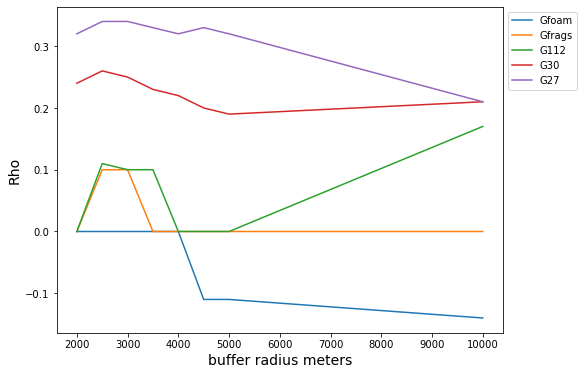

In [17]:
comps.replace("X", 0, inplace=True)
fig, ax = plt.subplots(figsize=(8,6))

data = comps[comps.code.isin(['G27', 'Gfrags', 'G30', 'Gfoam', 'G112'])].copy()
aval = "% to buildings"
variables=[aval]
data[[variables]] = data[variables].astype('float').round(2)
data.sort_values(by=aval, inplace=True)




sns.lineplot(data=data, x='dist', y=aval, hue='code')
ax.set_ylabel('Rho', fontsize=14)
ax.set_xlabel('buffer radius meters', fontsize=14)
plt.legend(bbox_to_anchor=(1,1), loc='upper left')
plt.show()

## Changes of land use profile for different buffer zones

In [18]:
check_dist = ['% to buildings', '% to trans', '% to recreation',  '% to agg', '% to woods', '% to unproductive', 'dist']
dfs = [element[check_dist].reset_index() for element in [sd_5000, sd_2000, sd_2500, sd_3000, sd_3500, sd_4000, sd_4500, sd_10000]]

x=pd.concat(dfs)
xlong = pd.melt(x, id_vars=['index', 'dist'], value_vars=check_dist[:-1])
xlong.groupby('variable').value.describe()

,count,mean,std,min,25%,50%,75%,max
variable,,,,,,,,
% to agg,1144.0,0.301343,0.191014,0.0,0.126568,0.291359,0.458758,1.000000
% to buildings,1144.0,0.192433,0.143238,0.0,0.076764,0.162299,0.272671,0.604194
% to recreation,1144.0,0.032810,0.033428,0.0,0.009074,0.023049,0.044549,0.241546
% to trans,1144.0,0.083693,0.055452,0.0,0.041163,0.074044,0.114068,0.281834
% to unproductive,1144.0,0.022149,0.037220,0.0,0.002116,0.007348,0.027451,0.383833
% to woods,1144.0,0.296770,0.192960,0.0,0.148270,0.275147,0.407042,0.848249


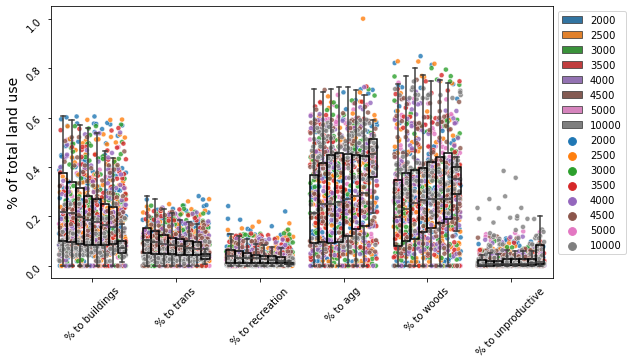

In [19]:
fig, ax = plt.subplots(figsize=(9,5))

props = {
 'boxprops':{'facecolor':'none', 'edgecolor':'black'},
    
}
sns.stripplot(data=xlong, x = 'variable', y='value', hue='dist', ax=ax, jitter=.4, zorder=0, alpha=0.8, edgecolor='white', linewidth=.5)
sns.boxplot(data=xlong, x='variable', y='value', ax=ax, hue='dist', **props, showfliers=False)
ax.tick_params(labelrotation=45)
ax.set_ylabel("% of total land use", fontsize=14)
ax.set_xlabel("")
plt.legend(bbox_to_anchor=(1,1), loc='upper left')
plt.show()

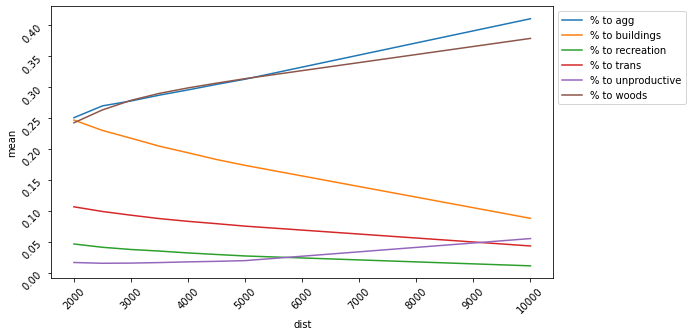

In [20]:
z = xlong.groupby(['variable', 'dist']).value.describe()['mean'].reset_index()
fig, ax = plt.subplots(figsize=(9,5))
sns.lineplot(data=z, x='dist', y='mean', hue='variable')
ax.tick_params(labelrotation=45)
plt.legend(bbox_to_anchor=(1,1), loc='upper left')
plt.show()

In [21]:
urbanone = fd[fd.location == 'maladaire']   

SyntaxError: invalid syntax (63008863.py, line 2)

In [ ]:
sd_5000

In [ ]:
sd_5000

In [ ]:
check_dist = ['% to buildings', '% to trans', '% to recreation',  '% to agg', '% to woods', '% to unproductive', 'dist']
dfs = [element[check_dist].reset_index() for element in [sd_5000, sd_2000, sd_2500, sd_3000, sd_3500, sd_4000, sd_4500, sd_10000]]

x=pd.concat(dfs)
xlong = pd.melt(x, id_vars=['index', 'dist'], value_vars=check_dist[:-1])
b = xlong[xlong['index'] == 'maladaire']
b

In [ ]:
x.head()

In [ ]:
xlong

In [ ]:
dfBeaches.columns

In [ ]:
dfBeaches.loc['maladaire'][[ '% to buildings', '% to trans', '% to recreation', '% to agg',
       '% to woods', '% to water', '% to unproductive', ]]

In [ ]:
dfBeaches.loc['quai-maria-belgia'][[ '% to buildings', '% to trans', '% to recreation', '% to agg',
       '% to woods', '% to water', '% to unproductive', ]]

In [ ]:
xlong[xlong['index'] == 'quai-maria-belgia']

### compare 1500m to the land use profile at 2000 - 10000

### for each land use category two barplots
### including industry
### 10 % of urban locations

x axis = buffer radius
y axis = % of total, color of land use profile

In [ ]:
locs = dfBeaches[dfBeaches["% to buildings"] < .36].location.unique()

In [ ]:
locs

In [ ]:
xlong['index'].unique() 

In [ ]:
locs

In [ ]:
c = xlong.loc[xlong['index'].isin(locs)]
c[c.variable == '% to buildings']['index'].unique()

In [ ]:
sns.stripplot(data=c[c.variable == "% to buildings"], x= 'dist', y = 'value', jitter=0.5)

In [ ]:
c[c.variable == "% to buildings"][:10]

In [ ]:
c['index'].unique()